In [1]:
import os
if os.getenv("COLAB_RELEASE_TAG"):
  COLAB = True
  from google.colab import userdata
  os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
  os.environ["WANDB_API_KEY"] = userdata.get('WANDB_API_KEY')
  os.environ["WANDB_LOG_MODEL"] = "end"
  os.environ["WANDB_PROJECT"] = "mthesis"
  from google.colab import drive
  drive.mount('/content/drive')
else:
  from dotenv import load_dotenv
  COLAB = False
  load_dotenv()
print(f"COLAB={COLAB}")

COLAB=False


In [2]:
if COLAB:
  !pip install datasets evaluate transformers[torch] wandb -q
  GDRIVE = "/content/drive/MyDrive/mthesis/"
else:
  GDRIVE = ""

In [1]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import evaluate
import torch
import wandb
import huggingface_hub
from tqdm import tqdm
from sklearn.metrics import accuracy_score


2024-08-20 15:15:03.423118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 15:15:03.578029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 15:15:03.635183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 15:15:03.652448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 15:15:03.764451: I tensorflow/core/platform/cpu_feature_guar

In [2]:
CUDA_AVAILABLE=torch.cuda.is_available()
print(f"CUDA={CUDA_AVAILABLE}")
device = "cuda" if CUDA_AVAILABLE else "cpu"
print(f"count={torch.cuda.device_count()}")
print(f"current={torch.cuda.get_device_name(torch.cuda.current_device())}")

CUDA=True
count=1
current=NVIDIA GeForce RTX 4070


In [7]:
# os.environ["WANDB_NOTEBOOK_NAME"] = "03_clip_zero_shot.ipynb"
# wandb.login()

In [4]:
HF_MODEL_PATH = "openai/clip-vit-base-patch16" #"openai/clip-vit-large-patch14" #"wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M"
TARGET_LABEL = "continent"

# RUN_NAME = "clip-base-32-224-continent-pretraining"
# OUTPUT_DIR = f"{GDRIVE}models/{RUN_NAME}"
# print(f"Output directory: {OUTPUT_DIR}")

# RESUME_FROM_CHECKPOINT=False
# WANDB_RUN_ID="ik4kauc1"
# CHECKPOINT_MODEL_PATH=f"{GDRIVE}models/{RUN_NAME}/checkpoint-2461" #"/content/models/vit-tiny-16-224-continent-base"

In [9]:
huggingface_hub.login(token=os.environ.get('HF_TOKEN'))
# ds = load_dataset("jrheiner/kerger_1024_v2")
# ds_im2gps = load_dataset("jrheiner/im2gps")
# ds_im2gps2k = load_dataset("jrheiner/im2gps2k")
ds = load_dataset("jrheiner/geo_training_v3") 

accuracy = evaluate.load("accuracy")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/s1/.cache/huggingface/token
Login successful


Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/23 [00:00<?, ?it/s]

In [10]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'longitude', 'latitude', 'country', 'continent', 'source'],
        num_rows: 177270
    })
    test: Dataset({
        features: ['image', 'image_id', 'longitude', 'latitude', 'country', 'continent', 'source'],
        num_rows: 7020
    })
    validation: Dataset({
        features: ['image', 'image_id', 'longitude', 'latitude', 'country', 'continent', 'source'],
        num_rows: 7020
    })
})

In [ ]:
# def get_mapping(dataset_split, label):
#     labels = dataset_split.features[label].names
#     label2id, id2label = dict(), dict()
#     for i, label in enumerate(labels):
#         label2id[label] = i
#         id2label[i] = label
#     return id2label, label2id, labels

# id2label, label2id, labels = get_mapping(ds["train"], TARGET_LABEL)
# labels

In [ ]:
# print(f"{id2label[ds['train'][0][TARGET_LABEL]]}, {ds['train'][0]['latitude']} {ds['train'][0]['longitude']}")
# ds["train"][0]["image"]

In [5]:
# from transformers import SiglipModel, SiglipProcessor

model = CLIPModel.from_pretrained("trainings/clip-ft-1e-6/clip-vit-base-patch16-continent-ft-best_LR_1e-6")
processor = CLIPProcessor.from_pretrained(HF_MODEL_PATH)
print(model.config)

CLIPConfig {
  "_name_or_path": "trainings/clip-ft-1e-6/clip-vit-base-patch16-continent-ft-best_LR_1e-6",
  "architectures": [
    "CLIPModel"
  ],
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 512,
  "text_config": {
    "bos_token_id": 0,
    "dropout": 0.0,
    "eos_token_id": 2,
    "model_type": "clip_text_model"
  },
  "torch_dtype": "float32",
  "transformers_version": "4.42.4",
  "vision_config": {
    "dropout": 0.0,
    "model_type": "clip_vision_model",
    "patch_size": 16
  }
}



In [7]:
model.torch_dtype

AttributeError: 'CLIPModel' object has no attribute 'torch_dtype'

In [ ]:
model.device

device(type='cpu')

In [ ]:
model = model.to(device)
model.device

device(type='cuda', index=0)

In [11]:
labels = ds["test"].unique(TARGET_LABEL)
print(labels)

['North America', 'Africa', 'Asia', 'Oceania', 'South America', 'Europe']


In [12]:
text_prompts = [f"A photo from {geo}." for geo in labels]
print(labels)
print(text_prompts)

['North America', 'Africa', 'Asia', 'Oceania', 'South America', 'Europe']
['A photo from North America.', 'A photo from Africa.', 'A photo from Asia.', 'A photo from Oceania.', 'A photo from South America.', 'A photo from Europe.']


In [18]:
# inputs = processor(text=text_prompts, images=ds["validation"][1000]["image"], padding="max_length", return_tensors="pt").to(device)
# with torch.no_grad():
#     outputs = model(**inputs)
# logits_per_image = outputs.logits_per_image
# probs = torch.sigmoid(logits_per_image).cpu() # these are the probabilities
# print(f"{probs.max()} that image is '{text_prompts[probs.argmax()]}'")


In [19]:
# i_ds = ds["validation"].to_iterable_dataset()
# i_ds

In [20]:
# def get_captions(batch):
#     batch_labels = [id2label[x] for x in batch[TARGET_LABEL]]
#     text_prompts = [f"A photo from {geo}." for geo in batch_labels]
#     return text_prompts

def get_captions(batch):
    batch_labels = batch[TARGET_LABEL]
    text_prompts = [f"A photo from {geo}." for geo in batch_labels]
    return text_prompts

In [21]:
# for idx, batch in enumerate(i_ds.iter(batch_size=3)):
#     print(get_captions(batch))
#     inputs = processor(text=get_captions(batch), images=batch["image"], return_tensors='pt', padding=True)
#     print(inputs)
#     print(inputs["input_ids"].shape)
#     print(inputs["attention_mask"].shape)
#     print(inputs["pixel_values"].shape)
#     break

In [22]:
# TEST_IDX=5000


# print(id2label[ds["train"][TEST_IDX]["country"]])

# inputs = processor(text=[f"A photo from {geo}." for geo in ds["train"].features["country"].names], images=ds["train"][TEST_IDX]["image"], return_tensors='pt', padding=True).to(device)

# with torch.no_grad():
#     outputs = model2(**inputs)
#     logits_per_image = outputs.logits_per_image
#     probs = logits_per_image.softmax(dim=-1)
#     batch_pred_idx = probs.argmax(axis=-1).to("cpu")
# print(probs)
# print(id2label[batch_pred_idx[0].item()])
# ds["train"][TEST_IDX]["image"]

In [21]:
# train_i_ds = ds["train"].to_iterable_dataset()
# val_i_ds = ds["validation"].to_iterable_dataset()

# config = {
#     'BATCH_SIZE': 64,
#     'EPOCHS': 10,
#     'LEARNING_RATE': 1e-6,
#     'TARGET': TARGET_LABEL
# }

# LOGGING_STEPS=100

# loss_img = torch.nn.CrossEntropyLoss()
# loss_txt = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=config["LEARNING_RATE"])

# print(f"{HF_MODEL_PATH} fine-tune")
# print(config)

# best_acc = 0
# for epoch in range(8, config["EPOCHS"]+1):
#     batch_losses = []
#     # Training
#     total=int(ds["train"].num_rows/config["BATCH_SIZE"])+1
#     training_pbar = tqdm(enumerate(train_i_ds.iter(batch_size=config["BATCH_SIZE"])), total=total, desc=f"Training Epoch {epoch}")
#     for idx, batch in training_pbar:
#         inputs = processor(text=get_captions(batch), images=batch["image"], return_tensors='pt', padding=True)
#         inputs = inputs.to(device)

#         optimizer.zero_grad()
#         outputs = model(**inputs, return_loss=True)
#         outputs.loss.backward()
#         optimizer.step()

#         batch_losses.append(outputs.loss.item())
#         training_pbar.set_postfix_str(f"Batch Loss: {outputs.loss.item():.4f}, Loss: {np.mean(batch_losses):.4f}")
#         if idx % LOGGING_STEPS==0:
#             with open(f"{GDRIVE}train_{HF_MODEL_PATH.split('/')[-1]}.csv", "a") as f:
#                 f.write(f"{epoch-1+(idx/total)},{np.mean(batch_losses)}\n")
    
#     # Validation
#     pred_ids = []
#     gt_ids = []
#     batch_losses = []
#     validation_pbar = tqdm(enumerate(val_i_ds.iter(batch_size=config["BATCH_SIZE"])), total=int(ds["validation"].num_rows/config["BATCH_SIZE"])+1, desc=f"Validation Epoch {epoch}")
#     for idx, batch in validation_pbar:
#         inputs = processor(text=get_captions(batch), images=batch["image"], return_tensors='pt', padding=True)
#         batch_gt_ids = batch[TARGET_LABEL]
#         gt_ids.extend(batch_gt_ids)

#         inputs = inputs.to(device)
#         with torch.no_grad():
#             outputs = model(**inputs)
#             logits_per_image = outputs.logits_per_image
#             probs = logits_per_image.softmax(dim=-1)
#             batch_pred_idx = probs.argmax(axis=-1).to("cpu")
        
#         logits_per_text = outputs.logits_per_text
#         total_loss = (loss_img(logits_per_image,torch.arange(len(logits_per_image), device=device)) + loss_txt(logits_per_text,torch.arange(len(logits_per_image), device=device)))/2
#         batch_losses.append(total_loss.item())
#         batch_pred_ids = np.array(batch_gt_ids)[batch_pred_idx].tolist()
#         pred_ids.extend(batch_pred_ids)
#         #acc = accuracy.compute(predictions=pred_ids, references=gt_ids)['accuracy']
#         acc = accuracy_score(y_true=gt_ids, y_pred=pred_ids)
#         validation_pbar.set_postfix_str(f"Loss: {np.mean(batch_losses):.4f}, Accuracy: {acc:.4f}")
#     if acc > best_acc:
#         model.save_pretrained(f"{GDRIVE}{HF_MODEL_PATH.split('/')[-1]}-{TARGET_LABEL}-ft-osv5m-best")
#     with open(f"{GDRIVE}validation_{HF_MODEL_PATH.split('/')[-1]}.csv", "a") as f:
#         f.write(f"{epoch},{np.mean(batch_losses)},{acc}\n")
        

In [33]:
i_ds = ds["test"].to_iterable_dataset()
loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()

BATCH_SIZE=8

print(f"{HF_MODEL_PATH} test {TARGET_LABEL}")
# print(config)

pred_ids = []
gt_ids = []
batch_losses = []

pbar = tqdm(enumerate(i_ds.iter(batch_size=BATCH_SIZE)), total=int(ds["test"].num_rows/BATCH_SIZE)+1)
for idx, batch in pbar:
    inputs = processor(text=text_prompts, images=batch["image"], return_tensors='pt', padding=True)
    # inputs = processor(text=get_captions(batch), images=batch["image"], return_tensors='pt', padding=True)
    batch_gt_ids = batch[TARGET_LABEL]
    gt_ids.extend(batch_gt_ids)

    inputs = inputs.to(device)


    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=-1)
        batch_pred_ids = probs.argmax(axis=-1).to("cpu")
    
    
    # logits_per_text = outputs.logits_per_text
    # total_loss = (loss_img(logits_per_image,torch.arange(len(logits_per_image), device=device)) + loss_txt(logits_per_text,torch.arange(len(logits_per_image), device=device)))/2
    # batch_losses.append(total_loss.item())

    # batch_pred_ids = np.array(batch_gt_ids)[batch_pred_idx].tolist()
    pred_ids.extend([labels[pred] for pred in batch_pred_ids])
    #Loss: {np.mean(batch_losses):.4f}, 
    pbar.set_postfix_str(f"Accuracy: {accuracy_score(y_true=gt_ids, y_pred=pred_ids):.4f}")
    # if idx == 5:
    #     break

openai/clip-vit-base-patch16 test country


100%|██████████| 878/878 [01:46<00:00,  8.25it/s, Accuracy: 0.5019]


In [130]:
# def get_mapping(dataset_split, label):
#     labels = dataset_split.features[label].names
#     label2id, id2label = dict(), dict()
#     for i, label in enumerate(labels):
#         label2id[label] = i
#         id2label[i] = label
#     return id2label, label2id, labels

# id2label_continent, label2id_continent, _ = get_mapping(ds["train"], "continent")
# id2label_country, label2id_country, _ = get_mapping(ds["train"], "country")

# def get_combined_captions(batch):
#     continent_labels = [id2label_continent[x] for x in batch["continent"]]
#     country_labels = [id2label_country[x] for x in batch["country"]]
#     text_prompts = [f"A photo from {country} in {continent}." for (continent, country) in zip(continent_labels, country_labels)]
#     return text_prompts


def get_combined_captions(batch):
    continent_labels = batch["continent"]
    country_labels = batch["country"]
    text_prompts = [f"A photo from {country} in {continent}." for (continent, country) in zip(continent_labels, country_labels)]
    return text_prompts

In [131]:
get_combined_captions(ds["train"].take(10))

['A photo from Nigeria in Africa.',
 'A photo from Argentina in South America.',
 'A photo from United States in North America.',
 'A photo from Australia in Oceania.',
 'A photo from Mali in Africa.',
 'A photo from Australia in Oceania.',
 'A photo from Argentina in South America.',
 'A photo from United States in North America.',
 'A photo from United Kingdom in Europe.',
 'A photo from Uzbekistan in Asia.']

In [132]:
train_i_ds = ds["train"].to_iterable_dataset()

config = {
    'BATCH_SIZE': 64,
    'EPOCHS': 10,
    'LEARNING_RATE': 1e-6,
}

LOGGING_STEPS=100

loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=config["LEARNING_RATE"])

print(f"{HF_MODEL_PATH} fine-tune (combined labels)")
print(config)

best_acc = 0
for epoch in range(4, config["EPOCHS"]+1):
    batch_losses = []
    # Training
    total=int(ds["train"].num_rows/config["BATCH_SIZE"])+1
    training_pbar = tqdm(enumerate(train_i_ds.iter(batch_size=config["BATCH_SIZE"])), total=total, desc=f"Training Epoch {epoch}")
    for idx, batch in training_pbar:
        inputs = processor(text=get_combined_captions(batch), images=batch["image"], return_tensors='pt', padding=True)
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, return_loss=True)
        outputs.loss.backward()
        optimizer.step()

        batch_losses.append(outputs.loss.item())
        training_pbar.set_postfix_str(f"Batch Loss: {outputs.loss.item():.4f}, Loss: {np.mean(batch_losses):.4f}")
        if idx % LOGGING_STEPS==0:
            with open(f"{GDRIVE}train_{HF_MODEL_PATH.split('/')[-1]}.csv", "a") as f:
                f.write(f"{epoch-1+(idx/total)},{np.mean(batch_losses)}\n")
    model.save_pretrained(f"{GDRIVE}{HF_MODEL_PATH.split('/')[-1]}-osv5m-combinedlabels-ft-e{epoch}")

openai/clip-vit-base-patch16 fine-tune (combined labels)
{'BATCH_SIZE': 64, 'EPOCHS': 10, 'LEARNING_RATE': 1e-06}


Training Epoch 4:   6%|▋         | 175/2770 [15:02<3:43:02,  5.16s/it, Batch Loss: 1.2709, Loss: 1.2759]


KeyboardInterrupt: 

In [ ]:
# from sklearn.metrics import classification_report, accuracy_score

# print(accuracy_score(y_true=gt_ids, y_pred=pred_ids))
# print(classification_report(y_true=gt_ids, y_pred=pred_ids))

South America
tensor([[2.2181e-04, 2.6450e-03, 3.4698e-04, 8.5704e-04, 1.0126e-04, 9.9583e-01]],
       device='cuda:0')
South America


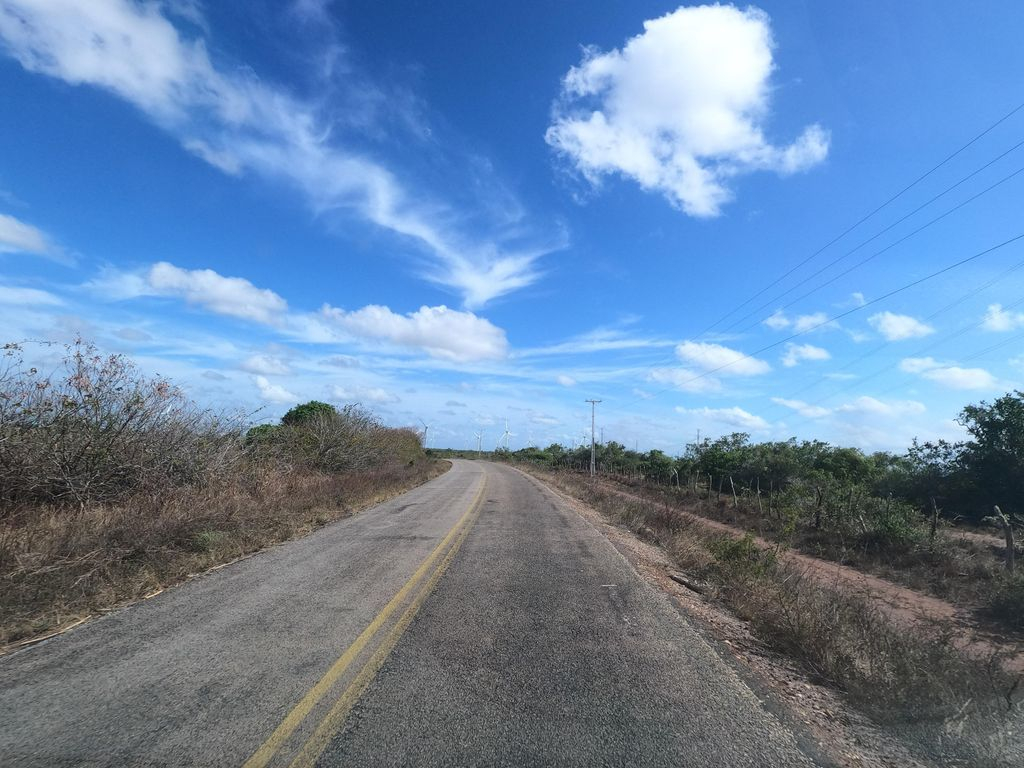

In [128]:
# TEST_IDX=42


# print(id2label[ds["test"][TEST_IDX]["continent"]])

# inputs = processor(text=[f"A photo from {geo}." for geo in ds["test"].features["continent"].names], images=ds["test"][TEST_IDX]["image"], return_tensors='pt', padding=True).to(device)

# with torch.no_grad():
#     outputs = model(**inputs)
#     logits_per_image = outputs.logits_per_image
#     probs = logits_per_image.softmax(dim=-1)
#     batch_pred_idx = probs.argmax(axis=-1).to("cpu")
# print(probs)
# print(id2label[batch_pred_idx[0].item()])
# ds["test"][TEST_IDX]["image"]

In [ ]:
# i_ds = ds["train"].to_iterable_dataset()

# loss_img = torch.nn.CrossEntropyLoss()
# loss_txt = torch.nn.CrossEntropyLoss()
# # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6,betas=(0.9,0.98),eps=1e-6,weight_decay=1e-4)
# # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)



# batch_losses = []

# BATCH_SIZE=64


# pbar = tqdm(enumerate(i_ds.iter(batch_size=BATCH_SIZE)), total=int(ds["train"].num_rows/BATCH_SIZE)+1)
# for idx, batch in pbar:
#     # inputs = processor(text=text_prompts, images=batch["image"], return_tensors='pt', padding=True)

#     inputs = processor(text=get_captions(batch), images=batch["image"], return_tensors='pt', padding=True)
#     # batch_gt_ids = batch[TARGET_LABEL]
#     # ground_truths = torch.arange(3, device=device)

#     # print(inputs)
#     # print(ground_truths)
#     # break

#     # print(batch["image_id"])

#     inputs = inputs.to(device)

#     optimizer.zero_grad()
#     outputs = model(**inputs, return_loss=True)
#     outputs.loss.backward()
#     optimizer.step()

#     batch_losses.append(outputs.loss.item())
#     pbar.set_postfix_str(f"Batch Loss: {outputs.loss.item():.4f}, Loss: {np.mean(batch_losses):.4f}")
#     # print(logits_per_image)
#     # print(ground_truths)

#     # print(outputs.loss)

#     # total_loss = (loss_img(logits_per_image,ground_truths) + loss_txt(logits_per_text,ground_truths))/2
#     # print(total_loss)


#     # targets = torch.nn.functional.softmax(
#     #         (logits_per_image @ logits_per_image.T), dim=-1
#     #     )
#     # print(targets)
#     # texts_loss = cross_entropy(logits_per_text, targets, reduction='none')
#     # images_loss = cross_entropy(logits_per_text.T, targets.T, reduction='none')
#     # loss =  (images_loss + texts_loss) / 2.0
#     # print(loss.mean())
#     # break
#     # logits_per_image = outputs.logits_per_image




#     # probs = logits_per_image.softmax(dim=-1)
#     # batch_pred_ids = probs.argmax(axis=-1).to("cpu")


In [ ]:
# model.save_pretrained("models/clip-vit-large-patch14-224-continent-half_e_finetuned")